# Goal:

After seeing the plot of 0.10 * Mean X vs. Y:

<img src="MeanXvsY.png" alt="Sample Image" width="500">

The question is:
- why do low mean X's have even lower Ys
- why do high mean X's have even higher Ys

Clearly, each value can't be perfectly linearly correlated, so one exploratory method is to spam interaction terms

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import itertools
import lightgbm as lgb

In [2]:
DIRECTORY = './data/'
train = pd.read_csv(DIRECTORY + 'train.csv').drop(columns='id')
train.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,5,8,5,8,6,4,4,3,3,4,...,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,...,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,...,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,...,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


In [22]:
features = train.drop(columns='FloodProbability')
initial_cols = features.columns


col_map = {}

# Multiplicative Features
for col1, col2 in itertools.combinations(initial_cols, 2):
    col_map[f'{col1}x{col2}'] = features[col1] * features[col2]

# Mean feature & interactions
mean_features = features.mean(axis=1)
col_map['mean'] = mean_features
for col in initial_cols:
    col_map[f'{col}xmean'] = features[col1] * mean_features

new_cols = pd.DataFrame(col_map)
features = pd.concat([features, new_cols], axis=1)


## Ridge

100%|██████████| 5/5 [00:15<00:00,  3.03s/it]


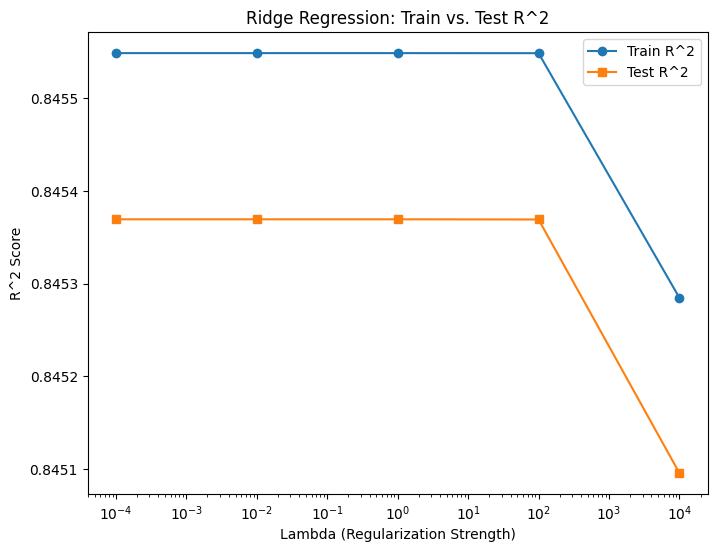

In [23]:
# Try ridge
X_train, X_test, y_train, y_test = train_test_split(features, train['FloodProbability'], test_size=0.2, random_state=42)

# Define lambda values (alpha in Ridge)
lambda_values = np.logspace(-4, 4, 5, base=10)
train_errors = []
test_errors = []

# Perform Ridge regression for each lambda
for alpha in tqdm(lambda_values):
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    train_errors.append(r2_score(y_train, model.predict(X_train)))
    test_errors.append(r2_score(y_test, model.predict(X_test)))

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(lambda_values, train_errors, label='Train R^2', marker='o')
plt.plot(lambda_values, test_errors, label='Test R^2', marker='s')
plt.xscale('log')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('R^2 Score')
plt.title('Ridge Regression: Train vs. Test R^2')
plt.legend()
plt.show()

## LGBM

In [25]:
X_train, X_test, y_train, y_test = train_test_split(features, train['FloodProbability'], test_size=0.2, random_state=42)
model = lgb.LGBMRegressor(num_leaves=31, n_estimators=1500, callbacks=)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19981
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 231
[LightGBM] [Info] Start training from score 0.504480


ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

In [29]:
predictions = model.predict(X_test)
r2_score(y_test, predictions)

0.8665021954609811

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

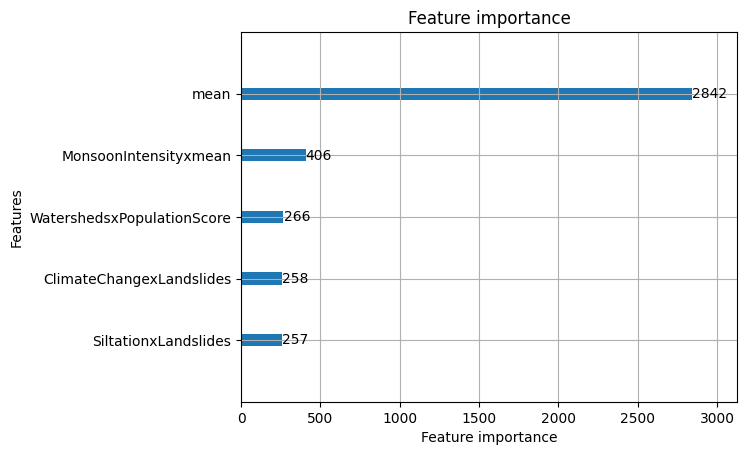

In [28]:
lgb.plot_importance(model, max_num_features=5)